In [1]:
import sys
import numpy as np
import random
import copy
import time
import pandas as pd
import matplotlib.pyplot as plt

random.seed(10)

# mbnpy toolkit
sys.path.append(r"C:\Users\jb622s\git\BNS-JT\BNS_JT") 
from BNS_JT import cpm, variable, quant

# Problem
## System
<figure>
<img src="img/house_power_prob.png" style="width:400px">
</figure>

The system consists of two power substations $S_0$ and $S_1$, eight transmission line poles $P_0$, ..., $P_7$, and seven houses $H_0$, ..., $H_6$. The substations and poles may fail being subjected to hazard scenarios $H$. Once a hazard event occurs, repair works will take place with priorities $S_0$ &rarr; $S_1$ &rarr; $P_0$ &rarr; $P_1$ &rarr; ... &rarr; $P_6$. The works are done only for failed components, and repairing a component takes a day.

Of interest is the expected number of days of power cut for each house. A house has power when the substation and poles it is connected to all survive. For example, $H_0$ has access to power if $S_0$ and $P_0$ are both in operation, while $H_1$ does if $S_0$, $P_0$, and $P_1$ are all in operation. We note that houses $H_3$ and $H_4$ have access to both substations and get power when either of the two link-sets is available. For example, $H_3$ has power either $S_0$, $P_2$, and $P_3$ work together or $S_1$ and $P_4$ are in operation.

## Bayesian network (BN) graph
The BN graph can be set up as below:
<figure>
<img src="img/power_house_bn.png" style="width:400px">
</figure>
 
The hazard node $H$ affects damage states of components, $S_0$, $S_1$, $P_0$, ..., $P_7$. Then, damage state of a component $X$ decides the rapair timing (i.e. how many days after a hazard occurrence) of a corresponding component, $T^X$. $T^X$ is also affected by the timing of the component right before in the repair priority, e.g. $T_1^S$ is dependent on $T^S_0$ as $S_0$ is right before $S_1$ in the repair priority. Then, actual closure time of each component, $C^X$ is decided by the corresponding damage state $X$ and $T^X$. That is, if $X$ has failed, then the closure time is the same as $T^X$, while if it is not, the closure time is zero. Finally, each house's duration of power cut, represneted by $H_0$, ..., $H_7$, is decided by the closure duration of components constituting their link-sets. For example, as aforementioned, teh first house has $S_0$ and $P_0$ in its link set, and therefore the node $H_0$ is connected to $C_0^S$ and $C^P_0$.

In the graph, random variables are represented by single border, while deterministic variables are represented by double border. 

# Modelling

## Hazard scenarios

In [2]:
cpms={}
vars={}

vars['haz'] = variable.Variable( name='haz', values=['mild','medi','inte'] ) # values=(mild, medium, intense)
cpms['haz'] = cpm.Cpm( variables=[vars['haz']], no_child=1, C=np.array([0,1,2]), p=[0.5,0.2,0.3] )

print(vars['haz'])
print(cpms['haz'])


"Variable(name=haz, B=[{0}, {1}, {2}, {0, 1}, {0, 2}, {1, 2}, {0, 1, 2}], values=['mild', 'medi', 'inte'])"
Cpm(variables=['haz'], no_child=1, C=[[0]
 [1]
 [2]], p=[[0.5]
 [0.2]
 [0.3]]


## Structural damage

In [3]:
# Substations
n_subs = 2
for i in range(n_subs):
    name = 'xs' + str(i)
    vars[name] = variable.Variable( name=name, values=['fail','surv'] ) # values=(failure, survival)
    cpms[name] = cpm.Cpm( variables = [vars[name], vars['haz']], no_child = 1,
                      C=np.array([[0,0], [1,0], [0,1], [1,1], [0,2], [1,2]]) )

cpms['xs0'].p = np.array([0.001, 0.999, 0.01, 0.99, 0.1, 0.9])
cpms['xs1'].p = np.array([0.005, 0.995, 0.05, 0.95, 0.2, 0.8])

# Poles
n_pole = 8
for i in range(n_pole):
    name = 'xp' + str(i)
    vars[name] = variable.Variable( name=name, values=['fail','surv'] ) # values=(failure, survival)
    cpms[name] = cpm.Cpm( variables = [vars[name], vars['haz']], no_child = 1,
                      C=np.array([[0,0], [1,0], [0,1], [1,1], [0,2], [1,2]]) )
    
    if i in [0,2,4,6]:
        cpms[name].p = np.array([0.001, 0.999, 0.01, 0.99, 0.1, 0.9])
    else:
        cpms[name].p = np.array([0.005, 0.995, 0.05, 0.95, 0.2, 0.8])


## Repair timing

In [4]:
max_ct = n_subs + n_pole 

# Repair priority
rep_pri = ['xs' + str(i) for i in range(n_subs)] + ['xp' + str(i) for i in range(n_pole)] # repair priority

print(rep_pri)


['xs0', 'xs1', 'xp0', 'xp1', 'xp2', 'xp3', 'xp4', 'xp5', 'xp6', 'xp7']


In [5]:
for i, x in enumerate(rep_pri):
    name = 't'+x[1:]
    vars[name] = variable.Variable( name=name, values=list(range(i+2)) )

    if i < 1: # first element
        cpms[name] = cpm.Cpm( variables = [vars[name], vars[x]], no_child = 1, C=np.array([[1,0], [0, 1]]), p=np.array([1,1]) )
    else:
        t_old_vars = vars[t_old].values

        Cx = np.empty(shape=(0,3), dtype=int)
        for v in t_old_vars:
            Cx_new = [[v, 1, v], [v+1, 0, v]]
            Cx = np.vstack( [Cx, Cx_new] )

        cpms[name] = cpm.Cpm( variables = [vars[name], vars[x], vars[t_old]], no_child = 1, C=Cx, p=np.ones(shape=(2*len(t_old_vars)), dtype=np.float32) )

    t_old = copy.deepcopy(name)


print(vars['ts0'])
print(cpms['ts0'])
print(" ")
print(vars['tp3'])
print(cpms['tp3'])

'Variable(name=ts0, B=[{0}, {1}, {0, 1}], values=[0, 1])'
Cpm(variables=['ts0', 'xs0'], no_child=1, C=[[1 0]
 [0 1]], p=[[1]
 [1]]
 
'Variable(name=tp3, B=[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {0, 1}, {0, 2}, {0, 3}, {0, 4}, {0, 5}, {0, 6}, {1, 2}, {1, 3}, {1, 4}, {1, 5}, {1, 6}, {2, 3}, {2, 4}, {2, 5}, {2, 6}, {3, 4}, {3, 5}, {3, 6}, {4, 5}, {4, 6}, {5, 6}, {0, 1, 2}, {0, 1, 3}, {0, 1, 4}, {0, 1, 5}, {0, 1, 6}, {0, 2, 3}, {0, 2, 4}, {0, 2, 5}, {0, 2, 6}, {0, 3, 4}, {0, 3, 5}, {0, 3, 6}, {0, 4, 5}, {0, 4, 6}, {0, 5, 6}, {1, 2, 3}, {1, 2, 4}, {1, 2, 5}, {1, 2, 6}, {1, 3, 4}, {1, 3, 5}, {1, 3, 6}, {1, 4, 5}, {1, 4, 6}, {1, 5, 6}, {2, 3, 4}, {2, 3, 5}, {2, 3, 6}, {2, 4, 5}, {2, 4, 6}, {2, 5, 6}, {3, 4, 5}, {3, 4, 6}, {3, 5, 6}, {4, 5, 6}, {0, 1, 2, 3}, {0, 1, 2, 4}, {0, 1, 2, 5}, {0, 1, 2, 6}, {0, 1, 3, 4}, {0, 1, 3, 5}, {0, 1, 3, 6}, {0, 1, 4, 5}, {0, 1, 4, 6}, {0, 1, 5, 6}, {0, 2, 3, 4}, {0, 2, 3, 5}, {0, 2, 3, 6}, {0, 2, 4, 5}, {0, 2, 4, 6}, {0, 2, 5, 6}, {0, 3, 4, 5}, {0, 3, 4, 6}, {0, 

## Closure time

In [6]:
i=1
name = 'cs' + str(i)
vals = vars['ts'+str(i)].values
#vars[name] = variable.Variable( name=name, values=vals )

print(vals)

st = vars['ts'+str(i)].B.index(set(vals))
print(st)

[0, 1, 2]
6


In [7]:
for x in rep_pri:
    name = 'c'+x[1:]
    name_t = 't'+x[1:]
    vals = vars[name_t].values
    vars[name] = variable.Variable( name=name, values=vals )

    ts_all = vars[name_t].B.index(set(vals))
    Cx = np.array([[0, 1, ts_all]])
    for v in vals:
        if v > 0:
            Cx = np.vstack((Cx, [v, 0, v]))

    cpms[name] = cpm.Cpm( variables = [vars[name], vars[x], vars[name_t]], no_child = 1, C=Cx, p=np.ones(shape=(len(Cx),1), dtype=np.float32) )


print(vars['cs0'])
print(cpms['cs0'])
print(" ")
print(vars['cp3'])
print(cpms['cp3'])

'Variable(name=cs0, B=[{0}, {1}, {0, 1}], values=[0, 1])'
Cpm(variables=['cs0', 'xs0', 'ts0'], no_child=1, C=[[0 1 2]
 [1 0 1]], p=[[1.]
 [1.]]
 
'Variable(name=cp3, B=[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {0, 1}, {0, 2}, {0, 3}, {0, 4}, {0, 5}, {0, 6}, {1, 2}, {1, 3}, {1, 4}, {1, 5}, {1, 6}, {2, 3}, {2, 4}, {2, 5}, {2, 6}, {3, 4}, {3, 5}, {3, 6}, {4, 5}, {4, 6}, {5, 6}, {0, 1, 2}, {0, 1, 3}, {0, 1, 4}, {0, 1, 5}, {0, 1, 6}, {0, 2, 3}, {0, 2, 4}, {0, 2, 5}, {0, 2, 6}, {0, 3, 4}, {0, 3, 5}, {0, 3, 6}, {0, 4, 5}, {0, 4, 6}, {0, 5, 6}, {1, 2, 3}, {1, 2, 4}, {1, 2, 5}, {1, 2, 6}, {1, 3, 4}, {1, 3, 5}, {1, 3, 6}, {1, 4, 5}, {1, 4, 6}, {1, 5, 6}, {2, 3, 4}, {2, 3, 5}, {2, 3, 6}, {2, 4, 5}, {2, 4, 6}, {2, 5, 6}, {3, 4, 5}, {3, 4, 6}, {3, 5, 6}, {4, 5, 6}, {0, 1, 2, 3}, {0, 1, 2, 4}, {0, 1, 2, 5}, {0, 1, 2, 6}, {0, 1, 3, 4}, {0, 1, 3, 5}, {0, 1, 3, 6}, {0, 1, 4, 5}, {0, 1, 4, 6}, {0, 1, 5, 6}, {0, 2, 3, 4}, {0, 2, 3, 5}, {0, 2, 3, 6}, {0, 2, 4, 5}, {0, 2, 4, 6}, {0, 2, 5, 6}, {0, 3, 4, 5}, {0, 3

## Power cut time

In [8]:
# Example 1
vars_p_h0 = [vars['cp0'], vars['cs0']]
M_h0, v_h0 = quant.sys_max_val('h0', vars_p_h0)

print(M_h0, v_h0)

# Example 2
vars_p_h1 = [vars['cp1'], vars['cp0'], vars['cs0']]
M_h1, v_h1 = quant.sys_max_val('h1', vars_p_h1)

print("")
print(M_h1, v_h1)

Cpm(variables=['h0', 'cp0', 'cs0'], no_child=1, C=[[0 0 0]
 [1 1 2]
 [2 2 2]
 [3 3 2]
 [1 0 1]], p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]] 'Variable(name=h0, B=[{0}, {1}, {2}, {3}, {0, 1}, {0, 2}, {0, 3}, {1, 2}, {1, 3}, {2, 3}, {0, 1, 2}, {0, 1, 3}, {0, 2, 3}, {1, 2, 3}, {0, 1, 2, 3}], values=[0, 1, 2, 3])'

Cpm(variables=['h1', 'cp1', 'cp0', 'cs0'], no_child=1, C=[[ 0  0  0  0]
 [ 1  1  4  2]
 [ 2  2 10  2]
 [ 3  3 14  2]
 [ 4  4 14  2]
 [ 1  0  1  2]
 [ 2  5  2  2]
 [ 3 15  3  2]
 [ 1  0  0  1]], p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] 'Variable(name=h1, B=[{0}, {1}, {2}, {3}, {4}, {0, 1}, {0, 2}, {0, 3}, {0, 4}, {1, 2}, {1, 3}, {1, 4}, {2, 3}, {2, 4}, {3, 4}, {0, 1, 2}, {0, 1, 3}, {0, 1, 4}, {0, 2, 3}, {0, 2, 4}, {0, 3, 4}, {1, 2, 3}, {1, 2, 4}, {1, 3, 4}, {2, 3, 4}, {0, 1, 2, 3}, {0, 1, 2, 4}, {0, 1, 3, 4}, {0, 2, 3, 4}, {1, 2, 3, 4}, {0, 1, 2, 3, 4}], values=[0, 1, 2, 3, 4])'


In [9]:
cut_lin = {} # cut-set of link-sets for each house

cut_lin['h0'] = [['cs0', 'cp0']]
cut_lin['h1'] = [['cs0', 'cp0', 'cp1']]
cut_lin['h2'] = [['cs0', 'cp2']]
cut_lin['h3'] = [['cs0', 'cp2', 'cp3'], ['cs1','cp4']]
cut_lin['h4'] = [['cs0', 'cp2', 'cp3', 'cp5'], ['cs1', 'cp4','cp5']]
cut_lin['h5'] = [['cs1', 'cp6']]
cut_lin['h6'] = [['cs1', 'cp6', 'cp7']]

for h, sets in cut_lin.items():
    if len(sets) == 1:              
        vars_h = [vars[x] for x in sets[0]]

        cpms[h], vars[h] = quant.sys_max_val( h, vars_h )
        
    else:
        names_hs = [h+str(i) for i in range(len(sets))]
        for h_i, s_i in zip(names_hs, sets):
            vars_h_i = [vars[x] for x in s_i]

            cpms[h_i], vars[h_i] = quant.sys_max_val( h_i, vars_h_i )
            
        vars_hs = [vars[n] for n in names_hs]
        cpms[h], vars[h] = quant.sys_min_val( h, vars_hs )
       

In [10]:
print(vars['h1'])
print(cpms['h1'])

print("")
print(vars['h3'])
print(cpms['h3'])

print("")
print(vars['h30'])
print(cpms['h30'])

'Variable(name=h1, B=[{0}, {1}, {2}, {3}, {4}, {0, 1}, {0, 2}, {0, 3}, {0, 4}, {1, 2}, {1, 3}, {1, 4}, {2, 3}, {2, 4}, {3, 4}, {0, 1, 2}, {0, 1, 3}, {0, 1, 4}, {0, 2, 3}, {0, 2, 4}, {0, 3, 4}, {1, 2, 3}, {1, 2, 4}, {1, 3, 4}, {2, 3, 4}, {0, 1, 2, 3}, {0, 1, 2, 4}, {0, 1, 3, 4}, {0, 2, 3, 4}, {1, 2, 3, 4}, {0, 1, 2, 3, 4}], values=[0, 1, 2, 3, 4])'
Cpm(variables=['h1', 'cs0', 'cp0', 'cp1'], no_child=1, C=[[ 0  0  0  0]
 [ 1  1  4  5]
 [ 1  0  1  5]
 [ 2  2  2 15]
 [ 3  2  3 25]
 [ 1  0  0  1]
 [ 2  2  4  2]
 [ 3  2 10  3]
 [ 4  2 14  4]], p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

'Variable(name=h3, B=[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {0, 1}, {0, 2}, {0, 3}, {0, 4}, {0, 5}, {0, 6}, {1, 2}, {1, 3}, {1, 4}, {1, 5}, {1, 6}, {2, 3}, {2, 4}, {2, 5}, {2, 6}, {3, 4}, {3, 5}, {3, 6}, {4, 5}, {4, 6}, {5, 6}, {0, 1, 2}, {0, 1, 3}, {0, 1, 4}, {0, 1, 5}, {0, 1, 6}, {0, 2, 3}, {0, 2, 4}, {0, 2, 5}, {0, 2, 6}, {0, 3, 4}, {0, 3, 5}, {0, 3, 6}, {0, 4, 5}, {0, 4, 6}, {0, 5, 6}, {1, 2, 3

# Inference

We apply conditioning on $H$ and variable elimination (VE) on other variables. For VE, we need to decide elimination order as $S_0$ &rarr; $T_0^S$ &rarr; $C^S_0$ &rarr; $S_1$ &rarr; $T_1^S$ &rarr; $C^S_1$ &rarr; $P_0$ &rarr; ... &rarr; $C_7^P$ &rarr; $H_0$ &rarr; $H_1$ &rarr; ... &rarr; $H_6$. 

In [11]:
n_hou = len(cut_lin)

VE_ord= ['haz']
for x in rep_pri:
    VE_ord.append(x)
    VE_ord.append('t'+x[1:])
    VE_ord.append('c'+x[1:])
VE_ord += ['h0', 'h1', 'h2']+['h30', 'h31', 'h3']+['h40', 'h41', 'h4'] + ['h5', 'h6']

Then, if we want to obtain the marginal distribution of $H_n$, $P(H_n)$ by summing out all other variables, we only need to consider those variables that are (grand, great grand, etc.) parents of $H_n$. 

For example, in case of $H_0$, we have those relevant variables as marked blue in the figure below:
<figure>
<img src="img/power_house_bn_h0.png" style="width:400px">
</figure>

The set of those relevant variables can be obtained using the function <span style="font-family:Consolas;">cpm.get_inf_vars</span>, as shown in the code below:

In [12]:
# Example 1
h_star1 = ['h0']
vars_inf1 = cpm.get_inf_vars( h_star1, cpms, VE_ord )
print(vars_inf1)

# Example 2
h_star2 = ['h0','h1']
vars_inf2 = cpm.get_inf_vars( h_star2, cpms, VE_ord )
print(vars_inf2)

['haz', 'xs0', 'ts0', 'cs0', 'xs1', 'ts1', 'xp0', 'tp0', 'cp0', 'h0']
['haz', 'xs0', 'ts0', 'cs0', 'xs1', 'ts1', 'xp0', 'tp0', 'cp0', 'xp1', 'tp1', 'cp1', 'h0', 'h1']


Now we perform inference.

Below, we calcualte $P(H_0)$ by first obtaining an inference scope (i.e. variables to consider) using <span style="font-family:Consolas;">cpm.get_inf_vars</span> and executing the conditioning-VE algorithm by <span style="font-family:Consolas;">cpm.cal_Msys_by_cond_VE</span>.

In [13]:
cond_names = ['haz']

# H0
vars_inf_h0 = cpm.get_inf_vars( ['h0'], cpms, VE_ord )
ve_names = [x for x in vars_inf_h0 if x not in cond_names]

Msys_h0 = cpm.cal_Msys_by_cond_VE( cpms, vars, cond_names, VE_ord, 'h0' )
print(Msys_h0)
print(sum(Msys_h0.p))

Cpm(variables=['h0'], no_child=1, C=[[0]
 [1]
 [2]
 [3]], p=[[9.38020500e-01]
 [5.34575025e-02]
 [7.92099500e-03]
 [6.01002500e-04]]
[1.]


We now calculate $P(H_6)$, which takes much longer than $H_0$ (in my desktop, it takes 30 seconds). This is because we now have more variables to consider because $T_7^P$ is in the last priority of repair, and thus all $T_x$ becomes relevant. The variables in the inference scope are marked below in the figure below:
<figure>
<img src="img/power_house_bn_h6.png" style="width:400px">
</figure>

One might consider applying sampling instead of the applied exact inference for faster calculation or a larger number of components (i.e. substations and poles).

In [14]:
# H7
vars_inf_h6 = cpm.get_inf_vars( ['h6'], cpms, VE_ord )
ve_names = [x for x in vars_inf_h6 if x not in cond_names]

Msys_h6 = cpm.cal_Msys_by_cond_VE( cpms, vars, cond_names, VE_ord, 'h6' )
print(Msys_h6)
print(sum(Msys_h6.p))

Cpm(variables=['h6'], no_child=1, C=[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]], p=[[8.46012488e-01]
 [8.37913635e-02]
 [3.87747064e-02]
 [2.13166722e-02]
 [7.92699644e-03]
 [1.86292686e-03]
 [2.84743240e-04]
 [2.82798049e-05]
 [1.76064092e-06]
 [6.24000037e-08]
 [9.60000006e-10]]
[1.]


# Final result

We now calculate for all houses.

In [15]:
VE_ord= ['haz']
for x in rep_pri:
    VE_ord.append(x)
    VE_ord.append('t'+x[1:])
    VE_ord.append('c'+x[1:])
VE_ord += ['h0', 'h1', 'h2']+['h30', 'h31', 'h3']+['h40', 'h41', 'h4'] + ['h5', 'h6']

Mhs = {}
for h in cut_lin.keys():
    st = time.time()

    Mhs[h] = cpm.cal_Msys_by_cond_VE( cpms, vars, cond_names, VE_ord, h )
    en = time.time()

    print( h + " Done. " + "Took {:.2f} sec.".format(en-st) )

h0 Done. Took 0.09 sec.
h1 Done. Took 0.26 sec.
h2 Done. Took 0.34 sec.
h3 Done. Took 35.99 sec.
h4 Done. Took 174.00 sec.
h5 Done. Took 8.34 sec.
h6 Done. Took 37.58 sec.


Using function <span style="font-family:Consolas;">cpm.get_means</span>, the average number of days of power cut can be calculated.

In [16]:
avg_cut_days = {}
for h in cut_lin.keys():
    days = cpm.get_means( Mhs[h], [h] )
    avg_cut_days[h] = days[0]

print(avg_cut_days)

{'h0': 0.07110250000000003, 'h1': 0.1549099875, 'h2': 0.08022550000000005, 'h3': 0.03758214298500002, 'h4': 0.16464348097007506, 'h5': 0.1408909975000001, 'h6': 0.26823448751250006}


# Mapping

To better understand the risks, we map the failure probabilities of structures (i.e. substations and poles) and the average number of affected days for houses.

In [17]:
# Locations for mapping
xdist, ydist = 0.8, 1.0
locs = {"h0": (-xdist, -ydist), "h1": (-2*xdist, -2*ydist), "h2": (xdist, -ydist), "h3": (2*xdist, -2*ydist), "h4": (xdist, -3*ydist), "h5": (5*xdist,-2*ydist), "h6": (6*xdist, -3*ydist)}
locs["s0"], locs["s1"] = (0.0, 0.0), (3.5*xdist, 0.0)
conn = {"p0": ('s0', 'h0'), "p1": ('h0', 'h1'), "p2": ('s0', 'h2'), "p3": ('h2', 'h3'), "p4": ('s1', 'h3'), "p5": ('h3', 'h4'), "p6": ('s1', 'h5'), "p7": ('h5', 'h6')}

for i in range(n_pole):
    p = 'p' + str(i)
    locs[p] = tuple( [0.5*sum(tup) for tup in zip(locs[conn[p][0]], locs[conn[p][1]])] )

In [18]:
# Gather data
cd_df = pd.DataFrame(columns=['name', 'loc_x', 'loc_y', 'avg_cut_days']) # cut days
for h in cut_lin.keys():
    cd_df = pd.concat( [cd_df, pd.DataFrame( [[h, locs[h][0], locs[h][1], avg_cut_days[h]]], columns=cd_df.columns )], ignore_index = True )

fr_df = pd.DataFrame( columns=['name', 'loc_x', 'loc_y', 'pf'] ) # failure probabilities 
for i in range(n_subs):
    x = 'xs' + str(i)
    xs = 's' +str(i)
    Mx = cpm.cal_Msys_by_cond_VE( cpms, vars, ['haz'], VE_ord, x )
    pf = cpm.get_prob( Mx, [x], [0] )
    fr_df = pd.concat( [fr_df, pd.DataFrame([[xs, locs[xs][0], locs[xs][1], pf]], columns=fr_df.columns)], ignore_index=True )

for i in range(n_pole):
    x = 'xp' + str(i)
    xs = 'p'+str(i)
    Mx = cpm.cal_Msys_by_cond_VE( cpms, vars, ['haz'], VE_ord, x )
    pf = cpm.get_prob( Mx, [x], [0] )
    fr_df = pd.concat( [fr_df, pd.DataFrame([[xs, locs[xs][0], locs[xs][1], pf]], columns=fr_df.columns)], ignore_index=True )

print(cd_df, '\n')
print(fr_df)

  name  loc_x  loc_y  avg_cut_days
0   h0   -0.8   -1.0      0.071103
1   h1   -1.6   -2.0      0.154910
2   h2    0.8   -1.0      0.080226
3   h3    1.6   -2.0      0.037582
4   h4    0.8   -3.0      0.164643
5   h5    4.0   -2.0      0.140891
6   h6    4.8   -3.0      0.268234 

  name  loc_x  loc_y      pf
0   s0    0.0    0.0  0.0325
1   s1    2.8    0.0  0.0725
2   p0   -0.4   -0.5  0.0325
3   p1   -1.2   -1.5  0.0725
4   p2    0.4   -0.5  0.0325
5   p3    1.2   -1.5  0.0725
6   p4    2.2   -1.0  0.0325
7   p5    1.2   -2.5  0.0725
8   p6    3.4   -1.0  0.0325
9   p7    4.4   -2.5  0.0725


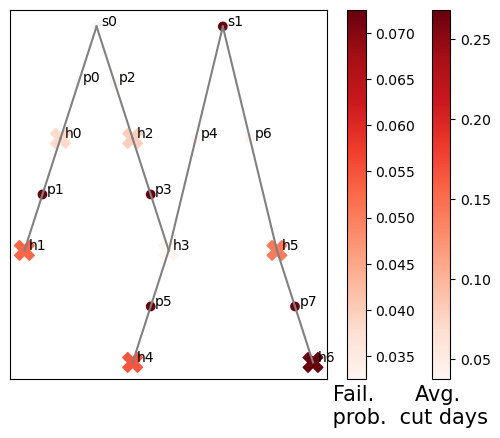

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for x, pair in conn.items():
    loc0, loc1 = locs[pair[0]], locs[pair[1]]
    plt.plot([loc0[0], loc1[0]], [loc0[1], loc1[1]], color='grey')

plt.scatter(cd_df['loc_x'].to_list(), cd_df['loc_y'].to_list(), c = cd_df['avg_cut_days'].to_list(), cmap='Reds', s=200, marker="X")
cb1 = plt.colorbar()
cb1.ax.set_xlabel('Avg. \n cut days', size = 15)

plt.scatter(fr_df['loc_x'].to_list(), fr_df['loc_y'].to_list(), c = fr_df['pf'].to_list(), cmap='Reds')
cb2 = plt.colorbar()
cb2.ax.set_xlabel('Fail. \n prob.', size = 15)

tx, ty = 0.10, 0.01
for i, name in enumerate(cd_df['name'].to_list()):
    ax.text(cd_df['loc_x'][i]+tx, cd_df['loc_y'][i]+ty, name)
for i, name in enumerate(fr_df['name'].to_list()):
    ax.text(fr_df['loc_x'][i]+tx, fr_df['loc_y'][i]+ty, name)

ax.set_xticks([])
ax.set_yticks([])
plt.show()


The figure above shows how the convolution of hazard risks, structural performance, and repair priority decides risks faced by houses.

For example, $H_1$ and $H_5$ show similar risk levels. $H_1$ is farther away from substation than $H_5$ but is connected to structures with higher repair priority. The two factors appear to compensate each other.

$H_3$ has the least risk being connected to both substations. Compared to $H_0$, the effect of such redundancy seems dominating other factors, i.e. structural performance and repair priority.